<a href="https://colab.research.google.com/github/syurenuko/-GDP-.ipynb/blob/main/%E3%80%90%E8%A1%9B%E6%98%9F%E7%94%BB%E5%83%8F%E8%A7%A3%E6%9E%90%E3%80%91%E5%A4%9C%E9%96%93%E5%85%89%E3%83%87%E3%83%BC%E3%82%BF%E3%81%8B%E3%82%89%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%82%92%E4%BD%BF%E3%81%A3%E3%81%A6GDP%E3%82%92%E6%8E%A8%E5%AE%9A%E3%81%99%E3%82%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sh > /dev/null
!pip install rasterio > /dev/null
!pip install geopandas > /dev/null

In [2]:
#必要なライブラリをimportする
import os
from sh import wget, gunzip, mv
import tarfile
import rasterio
import rasterio.mask

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import json
from pandas.io.json import json_normalize
import geopandas as gpd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import lightgbm as lgb
from sklearn.metrics import r2_score


import warnings
warnings.simplefilter('ignore')

In [3]:
# データ保存用のディレクトリ'data'を作成
if not os.path.exists('data'):
    os.mkdir('data')

夜間光データ（2009年）をダウンロードする

In [4]:
#　2009年の夜間光データを持ってくる
# ダウンロード対象のURLを作成
target_data = 'F162009'
url = f'https://ngdc.noaa.gov/eog/data/web_data/v4composites/{target_data}.v4.tar'

# データのダウンロード
wget(url)

# 圧縮ファイルの解凍（該当ファイルのみ抽出）
with tarfile.open(f'/content/{target_data}.v4.tar') as tar:
    # stable_lights.avg_vis.tif.gzというファイル名を取得
    file = [tarinfo for tarinfo in tar.getmembers() if tarinfo.name.endswith("web.stable_lights.avg_vis.tif.gz")]
    # 対象ファイルを解凍（.gz）
    tar.extractall(path='/content/', members=[file[0]])
    # 対象ファイルを解凍（Unzip）
    gunzip(f'/content/{target_data}.v4b_web.stable_lights.avg_vis.tif.gz')
    # 対象ファイルの移動
    mv(f'/content/{target_data}.v4b_web.stable_lights.avg_vis.tif', '/content/data/')

In [5]:
# numpy形式で読み込み
with rasterio.open('/content/data/F162009.v4b_web.stable_lights.avg_vis.tif') as src:  
    data = src.read()

geojson形式のベクターファイルをダウンロード

In [6]:
# ベクターファイルのダウンロード
wget('https://datahub.io/core/geo-countries/r/countries.geojson')  

In [7]:
# geojsonファイルの読み込み
countries = gpd.read_file('/content/countries.geojson')

In [8]:
#geojsonファイルの中身確認
countries

,ADMIN,ISO_A3,geometry
0,Aruba,ABW,"POLYGON ((-69.99694 12.57758, -69.93639 12.531..."
1,Afghanistan,AFG,"POLYGON ((71.04980 38.40866, 71.05714 38.40903..."
2,Angola,AGO,"MULTIPOLYGON (((11.73752 -16.69258, 11.73851 -..."
3,Anguilla,AIA,"MULTIPOLYGON (((-63.03767 18.21296, -63.09952 ..."
4,Albania,ALB,"POLYGON ((19.74777 42.57890, 19.74601 42.57993..."
...,...,...,...
250,Samoa,WSM,"MULTIPOLYGON (((-171.57002 -13.93816, -171.564..."
251,Yemen,YEM,"MULTIPOLYGON (((53.30824 12.11839, 53.31027 12..."
252,South Africa,ZAF,"MULTIPOLYGON (((37.86378 -46.94085, 37.83644 -..."
253,Zambia,ZMB,"POLYGON ((31.11984 -8.61663, 31.14102 -8.60619..."


各国の夜間光データの可視化

In [9]:
def load_ntl(target_data, area):
    # TIFファイルから該当エリアのデータを抽出
    with rasterio.open(f'/content/data/{target_data}.v4b_web.stable_lights.avg_vis.tif') as src:
        out_image, out_transform = rasterio.mask.mask(src, countries.query(f'ISO_A3 == "{area}"').geometry, crop=True)
    return out_image

# 可視化用の関数
def show(data):
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.imshow(data[0])
    plt.subplot(122)
    #光を発している部分の可視化
    plt.hist(data.reshape(-1), bins=np.arange(1, 63, 1))

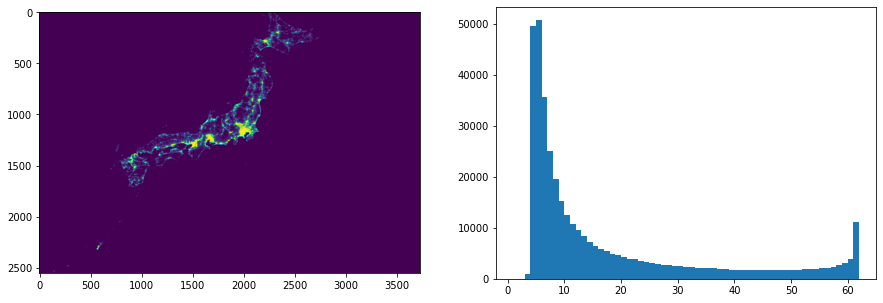

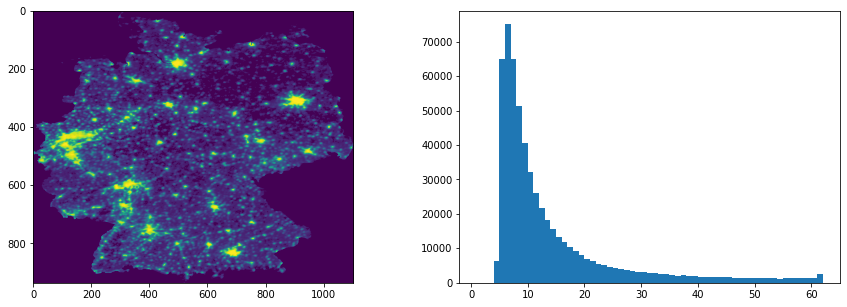

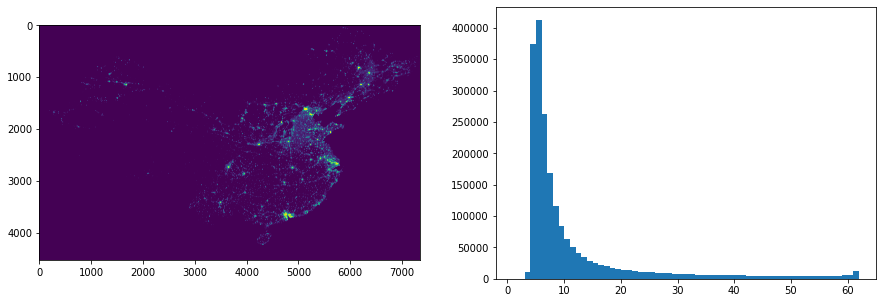

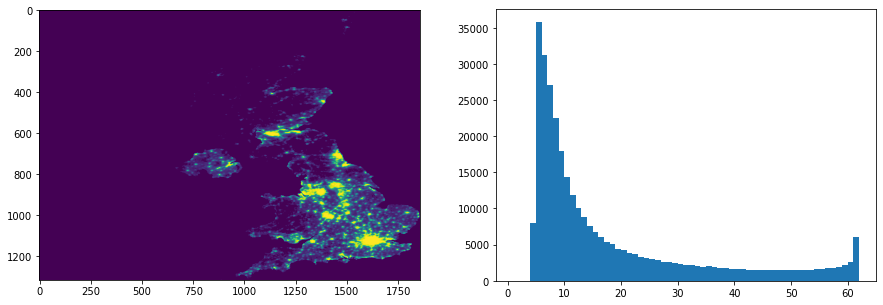

In [10]:
# 日本・アメリカ・中国・イギリスのデータを取得、可視化
japan_2009 = load_ntl(target_data='F162009', area='JPN')
germany_2009 = load_ntl(target_data='F162009', area='DEU')
china_2009 = load_ntl(target_data='F162009', area='CHN')
uk_2009 = load_ntl(target_data='F162009', area='GBR')

show(japan_2009)
show(germany_2009)
show(china_2009)
show(uk_2009)

#名前変える

函館の夜間光可視化

国土交通省の「国土数値情報」から市町村の行政区域データを持ってきます。
wgetでデータ持ってこれるようにしたかったのですが、なぜかzipファイルの中身が不完全の状態でダウンロードされてしまったので、手動でウェブサイトからダウンロードしてColabにアップロードしています。
使用しているのは令和2年北海道の行政区域データN03-20200101_01_GML.zipの中にある"N03-20_01_200101.geojson"です。

該当ページリンク　https://nlftp.mlit.go.jp/ksj/gml/datalist/KsjTmplt-N03-v2_4.html#prefecture

In [11]:
# geojsonファイルの読み込み
city = gpd.read_file('/content/N03-20_01_200101.geojson')
# 中身の確認
city

,N03_001,N03_002,N03_003,N03_004,N03_007,_color,_opacity,_weight,_fillColor,_fillOpacity,geometry
0,北海道,石狩振興局,札幌市,中央区,01101,#3388ff,1,3,#3388ff,0.2,"POLYGON ((141.25743 42.99782, 141.25724 42.997..."
1,北海道,石狩振興局,札幌市,北区,01102,#3388ff,1,3,#3388ff,0.2,"POLYGON ((141.33333 43.07497, 141.33331 43.075..."
2,北海道,石狩振興局,札幌市,東区,01103,#3388ff,1,3,#3388ff,0.2,"POLYGON ((141.37500 43.06851, 141.37370 43.068..."
3,北海道,石狩振興局,札幌市,白石区,01104,#3388ff,1,3,#3388ff,0.2,"POLYGON ((141.36645 43.05797, 141.36665 43.058..."
4,北海道,石狩振興局,札幌市,豊平区,01105,#3388ff,1,3,#3388ff,0.2,"POLYGON ((141.36365 42.94124, 141.36366 42.941..."
...,...,...,...,...,...,...,...,...,...,...,...
9513,北海道,根室振興局,蘂取郡,蘂取村,01700,#3388ff,1,3,#3388ff,0.2,"POLYGON ((148.76893 45.55595, 148.76894 45.555..."
9514,北海道,根室振興局,蘂取郡,蘂取村,01700,#3388ff,1,3,#3388ff,0.2,"POLYGON ((148.77259 45.55665, 148.77260 45.556..."
9515,北海道,根室振興局,蘂取郡,蘂取村,01700,#3388ff,1,3,#3388ff,0.2,"POLYGON ((148.78945 45.55598, 148.78957 45.555..."
9516,北海道,根室振興局,蘂取郡,蘂取村,01700,#3388ff,1,3,#3388ff,0.2,"POLYGON ((148.87741 45.52740, 148.87743 45.527..."


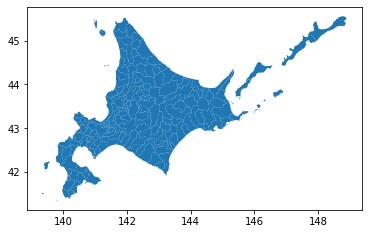

In [12]:
#plotするとちゃんと北海道
city.plot()

In [13]:
#函館市のデータを確認
city.query('N03_004=="函館市"')

,N03_001,N03_002,N03_003,N03_004,N03_007,_color,_opacity,_weight,_fillColor,_fillOpacity,geometry
10,北海道,渡島総合振興局,,函館市,01202,#3388ff,1,3,#3388ff,0.2,"POLYGON ((140.89877 41.74728, 140.89880 41.747..."
11,北海道,渡島総合振興局,,函館市,01202,#3388ff,1,3,#3388ff,0.2,"POLYGON ((140.96223 41.70951, 140.96227 41.709..."
12,北海道,渡島総合振興局,,函館市,01202,#3388ff,1,3,#3388ff,0.2,"POLYGON ((140.96879 41.71007, 140.96885 41.710..."
13,北海道,渡島総合振興局,,函館市,01202,#3388ff,1,3,#3388ff,0.2,"POLYGON ((140.97063 41.71068, 140.97065 41.710..."
14,北海道,渡島総合振興局,,函館市,01202,#3388ff,1,3,#3388ff,0.2,"POLYGON ((140.97329 41.71146, 140.97335 41.711..."
...,...,...,...,...,...,...,...,...,...,...,...
146,北海道,渡島総合振興局,,函館市,01202,#3388ff,1,3,#3388ff,0.2,"POLYGON ((141.09704 41.87792, 141.09704 41.877..."
147,北海道,渡島総合振興局,,函館市,01202,#3388ff,1,3,#3388ff,0.2,"POLYGON ((141.12165 41.86445, 141.12167 41.864..."
148,北海道,渡島総合振興局,,函館市,01202,#3388ff,1,3,#3388ff,0.2,"POLYGON ((141.12268 41.86506, 141.12267 41.865..."
149,北海道,渡島総合振興局,,函館市,01202,#3388ff,1,3,#3388ff,0.2,"POLYGON ((141.11741 41.86859, 141.11745 41.868..."


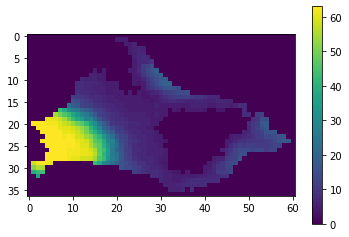

In [14]:
with rasterio.open('/content/data/F162009.v4b_web.stable_lights.avg_vis.tif') as src:
    out_image, out_transform = rasterio.mask.mask(src, city.query('N03_004=="函館市"').geometry, crop=True)

# データの可視化
plt.imshow(out_image[0])
plt.colorbar()

DataHub.ioからGDPデータをダウンロード

In [15]:
#GDPデータのダウンロード
wget('https://datahub.io/core/gdp/r/0.csv')

In [16]:
#指数表記を避けるため小数点以下第2位まで表示されるように設定
pd.options.display.float_format = '{:.2f}'.format
# geojsonファイルの読み込み
gdp = pd.read_csv('/content/0.csv')
# 中身の確認
gdp

,Country Name,Country Code,Year,Value
0,Arab World,ARB,1968,25760683041.09
1,Arab World,ARB,1969,28434203615.48
2,Arab World,ARB,1970,31385499664.07
3,Arab World,ARB,1971,36426909888.39
4,Arab World,ARB,1972,43316056615.46
...,...,...,...,...
11502,Zimbabwe,ZWE,2012,14242490252.43
11503,Zimbabwe,ZWE,2013,15451768658.55
11504,Zimbabwe,ZWE,2014,15891049235.99
11505,Zimbabwe,ZWE,2015,16304667807.07


特徴量生成に使う関数

In [17]:
#合計光量を求める関数
def sumlight(u, counts):
  i=0
  A=0
  for i in range(len(u)):
    A = A + u[i]*counts[i]
    i = i + 1
    
  return A 

In [18]:
#平均光量を求める関数
def meanlight(sumlight,len):
  mean = sumlight/len

  return mean

In [19]:
#光量0を取り除くl関数
def delete_0(u, count):
  u_delete=np.delete(u, np.where(u == 0))
  counts_delete = np.delete(count, np.where(u == 0))

  return u_delete, counts_delete

In [20]:
#光量63をカウントする関数
def counts_63(u_delete, counts_delete):
  if any(u_delete==63):
    where_63 = np.where(u_delete == 63)
    sum_63 = counts_delete[where_63]
  else : 
    sum_63 = 0

  return sum_63

In [21]:
#光量の最頻値を求める関数
def mode(u_delete, counts_delete):
  where_mode = np.where(counts_delete == counts_delete.max())
  nightlight_mode = u_delete[where_mode]

  return nightlight_mode[0]

In [22]:
#光量のばらつき(変動係数)を求める関数
def variation(counts_delete):
  mean = counts_delete.mean()
  std = counts_delete.std()
  variation = mean / std 

  return variation

In [23]:
#特徴量のcolumns
cols = ['country', 'gdp', "SumLight", "MeanLight", "Area", "Counts_63", "Percentage_63", "Mode", "Variation"]
#空のPandasDataFrame、NightLightを作成(以下のif文で一致する国が202ということが事前にわかったので202行にしています)
NightLight = pd.DataFrame(np.zeros([202, 9]), columns=cols)

In [24]:
#NightLightを作成
i=0
j=0
for i in range(len(countries["ISO_A3"])):
  # gdpの""Country Code"にcountriesの"ISO_A3"が含まれており、かつ２００９年のデータがあるものを抽出
  if any(gdp['Country Code'].isin([countries["ISO_A3"][i]])) & (any(gdp["Year"][gdp["Country Code"]==countries["ISO_A3"][i]]==2009)):

    #以下NightLightに特徴量となるデータを入れていく

    #国名
    NightLight["country"][j]= countries["ISO_A3"][i] 
    #GDP
    NightLight["gdp"][j]=gdp["Value"][(gdp["Country Code"]==countries["ISO_A3"][i])&(gdp["Year"]==2009)]

   
    #データの読み込んで、一次元配列に変換する
    A = load_ntl(target_data='F162009', area=countries["ISO_A3"][i]).reshape(-1)
    #0~63段階の光量を表したu、　それぞれの光量をカウントしたcounts
    u, counts = np.unique(A, return_counts=True)

    #光量0の部分を取り除く
    u_delete, counts_delete = delete_0(u, counts)

    #合計光量
    NightLight["SumLight"][j] = sumlight(u_delete, counts_delete)
    #平均光量
    NightLight["MeanLight"][j] = meanlight(sumlight(u_delete, counts_delete), counts_delete.sum())
    #面積(1~63までの光量を発しているエリアの合計）
    NightLight["Area"][j] = counts_delete.sum()
    #光量63の合計
    NightLight["Counts_63"][j] = counts_63(u_delete, counts_delete)
    #光量63の割合
    NightLight["Percentage_63"][j] = NightLight["Counts_63"][j] / NightLight["Area"][j]
    #光量の最頻値を求める関数
    NightLight["Mode"][j] = mode(u_delete, counts_delete)
    #光量のばらつき(変動係数)
    NightLight["Variation"][j] = variation(counts_delete)


    j = j + 1

In [25]:
#中身の確認
NightLight

,country,gdp,SumLight,MeanLight,Area,Counts_63,Percentage_63,Mode,Variation
0,ABW,2498932960.89,6623.00,33.12,200.00,16.00,0.08,63.00,1.33
1,AFG,12486943505.74,96733.00,9.61,10063.00,0.00,0.00,4.00,0.35
2,AGO,75492384801.37,160713.00,12.97,12391.00,297.00,0.02,5.00,0.48
3,ALB,12044212903.82,103545.00,7.91,13084.00,0.00,0.00,4.00,0.31
4,AND,3660530702.97,16499.00,24.52,673.00,0.00,0.00,6.00,1.50
...,...,...,...,...,...,...,...,...,...
197,WSM,560959527.82,1852.00,5.02,369.00,0.00,0.00,3.00,0.39
198,YEM,25130274124.25,387100.00,8.93,43372.00,190.00,0.00,4.00,0.31
199,ZAF,297216730668.94,2242424.00,10.79,207909.00,3217.00,0.02,4.00,0.42
200,ZMB,15328342303.96,106460.00,12.99,8198.00,102.00,0.01,6.00,0.49


各特徴量とGDPの関係可視化

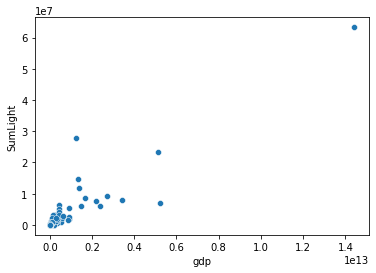

In [26]:
#SumLight（合計光量）とGDPの関係
sns.scatterplot(data=NightLight, x='gdp', y='SumLight')
plt.show()

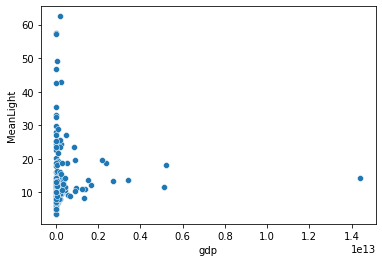

In [27]:
#MeanLight（平均光量）とGDPの関係
sns.scatterplot(data=NightLight, x='gdp', y='MeanLight')
plt.show()

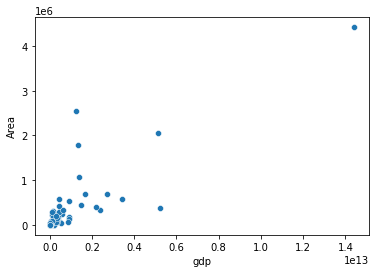

In [28]:
#Area（面積）　とGDPの関係
sns.scatterplot(data=NightLight, x='gdp', y='Area')
plt.show()

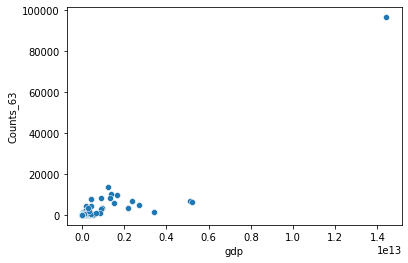

In [29]:
#Counts_63（最大光量63の数）　とGDPの関係
sns.scatterplot(data=NightLight, x='gdp', y='Counts_63')
plt.show()

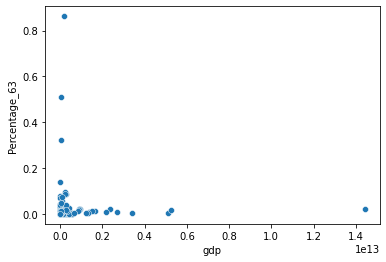

In [30]:
#Percentage_63（光量63の割合）　とGDPの関係
sns.scatterplot(data=NightLight, x='gdp', y='Percentage_63')
plt.show()

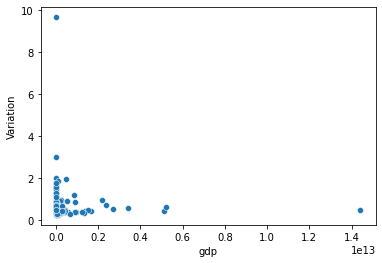

In [31]:
#Variation（国の光量のばらつき(変動係数)）　とGDPの関係
sns.scatterplot(data=NightLight, x='gdp', y='Variation')
plt.show()

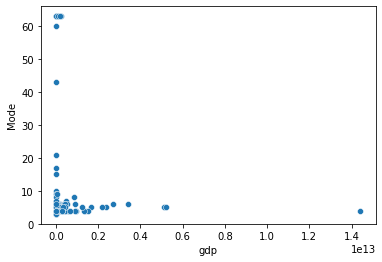

In [32]:
#Mode(光量1~63の中での最頻値)とGDPの関係
sns.scatterplot(data=NightLight, x='gdp', y='Mode')
plt.show()

光量が強い地域を見てみる(Mode順でソート)

In [33]:
#Modeで降順ソート
NightLight.sort_values("Mode", ascending=False).head(10)

,country,gdp,SumLight,MeanLight,Area,Counts_63,Percentage_63,Mode,Variation
0,ABW,2498932960.89,6623.00,33.12,200.00,16.00,0.08,63.00,1.33
113,MAC,21475520709.39,1956.00,57.53,34.00,11.00,0.32,63.00,0.90
77,HKG,214046415026.19,56262.00,42.88,1312.00,128.00,0.10,63.00,0.97
19,BHR,22938218085.11,37561.00,49.16,764.00,390.00,0.51,63.00,0.26
150,PRI,96385638000.00,316596.00,28.99,10919.00,477.00,0.04,63.00,1.87
162,SGP,192408387762.12,37193.00,62.51,595.00,513.00,0.86,63.00,0.32
123,MLT,8528202278.41,21889.00,46.87,467.00,65.00,0.14,63.00,0.85
115,MCO,5557245122.32,1715.00,57.17,30.00,0.00,0.00,60.00,1.15
166,SMR,2363156432.34,4037.00,42.49,95.00,0.00,0.00,43.00,1.58
24,BMU,5806378000.00,3255.00,35.38,92.00,1.00,0.01,21.00,1.77


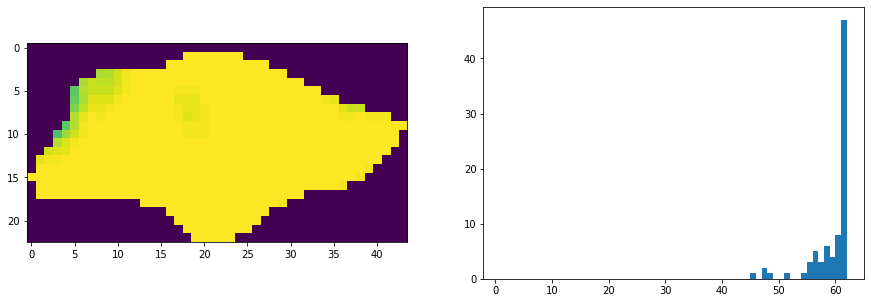

In [34]:
#シンガポールの夜間光画像
SGP_2009 = load_ntl(target_data='F162009', area='SGP')

show(SGP_2009)

GDPの外れ値（第一四分位数ー1.5×四分位範囲以下 or 第三四分位数＋1.5×四分位範囲以上）を取る国をデータから削除

In [35]:
#GDPの外れ値を取る国をNightLightから削除
q1= NightLight["gdp"].quantile(0.25)
q2= NightLight["gdp"].quantile(0.75)
iqr=q2-q1


max= q2 + 1.5*(iqr) #範囲指定max
min= q1 - 1.5*(iqr) #範囲指定min
NightLight = NightLight[(NightLight["gdp"]> min) & (NightLight["gdp"] < max)]
NightLight

,country,gdp,SumLight,MeanLight,Area,Counts_63,Percentage_63,Mode,Variation
0,ABW,2498932960.89,6623.00,33.12,200.00,16.00,0.08,63.00,1.33
1,AFG,12486943505.74,96733.00,9.61,10063.00,0.00,0.00,4.00,0.35
2,AGO,75492384801.37,160713.00,12.97,12391.00,297.00,0.02,5.00,0.48
3,ALB,12044212903.82,103545.00,7.91,13084.00,0.00,0.00,4.00,0.31
4,AND,3660530702.97,16499.00,24.52,673.00,0.00,0.00,6.00,1.50
...,...,...,...,...,...,...,...,...,...
196,VUT,610066628.69,4247.00,10.09,421.00,0.00,0.00,4.00,0.65
197,WSM,560959527.82,1852.00,5.02,369.00,0.00,0.00,3.00,0.39
198,YEM,25130274124.25,387100.00,8.93,43372.00,190.00,0.00,4.00,0.31
200,ZMB,15328342303.96,106460.00,12.99,8198.00,102.00,0.01,6.00,0.49


目的変数と説明変数に分離

In [36]:
#Objective（目的変数）とExplanatory（説明変数）の分離
Objective = NightLight[["SumLight","MeanLight","Area","Counts_63","Percentage_63","Mode","Variation"]]
Explanatory = NightLight[["gdp"]]

学習データと検証データに分ける

In [37]:
#学習データと検証データに分ける(学習データ128個、検証データ43個)
train_x, valid_x, train_y, valid_y = train_test_split(Objective, Explanatory, test_size=0.25, random_state=42, shuffle=True)

In [38]:
#中身を確認
train_x

,SumLight,MeanLight,Area,Counts_63,Percentage_63,Mode,Variation
171,288508.00,12.27,23521.00,45.00,0.00,6.00,0.54
31,3406.00,8.41,405.00,0.00,0.00,5.00,0.46
174,2870.00,10.32,278.00,0.00,0.00,7.00,0.68
179,422933.00,10.37,40798.00,184.00,0.00,4.00,0.40
187,31579.00,11.98,2635.00,4.00,0.00,5.00,0.43
...,...,...,...,...,...,...,...
88,126592.00,15.97,7927.00,73.00,0.01,6.00,0.68
127,4295.00,14.04,306.00,0.00,0.00,4.00,0.88
18,603350.00,7.34,82152.00,36.00,0.00,4.00,0.30
112,200577.00,10.81,18554.00,13.00,0.00,5.00,0.40


In [39]:
#中身を確認
valid_x

,SumLight,MeanLight,Area,Counts_63,Percentage_63,Mode,Variation
122,40965.00,12.70,3225.00,43.00,0.01,5.00,0.52
68,8533.00,14.25,599.00,1.00,0.00,5.00,0.53
69,1570.00,10.90,144.00,0.00,0.00,5.00,0.75
165,141885.00,8.94,15872.00,78.00,0.00,4.00,0.35
185,22.00,3.67,6.00,0.00,0.00,4.00,3.00
97,18948.00,26.99,702.00,22.00,0.03,17.00,1.52
161,59763.00,10.02,5962.00,56.00,0.01,4.00,0.33
125,49049.00,11.66,4207.00,0.00,0.00,5.00,0.53
130,35774.00,14.37,2490.00,0.00,0.00,5.00,0.71
129,19261.00,13.50,1427.00,26.00,0.02,4.00,0.43


LightGBMで学習する

In [ ]:
#LightGBMで学習

In [40]:
#KFoldを使って5分割交差検証
from sklearn.model_selection import KFold
fold = KFold(n_splits=5, shuffle=True, random_state=42)
cv=list(fold.split(train_x, train_y))

In [41]:
# testデータの予測用
pred = np.zeros(valid_y.shape[0])

In [42]:
#パラメーター設定
params = {
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'objective': 'regression',
    'seed': 42,
    'learning_rate': 0.01,
    "n_jobs": -1,
    "verbose": -1,
}

In [43]:
for tr_idx, val_idx in cv:  
    x_tr, x_va = train_x.iloc[tr_idx], train_x.iloc[val_idx]
    y_tr, y_va = train_y.iloc[tr_idx], train_y.iloc[val_idx]
    
    # Datasetに入れて学習させる
    train_set = lgb.Dataset(x_tr, y_tr)
    val_set = lgb.Dataset(x_va, y_va, reference=train_set)
        
    # Training
    model = lgb.train(params, train_set, num_boost_round=10000, early_stopping_rounds=100,
                      valid_sets=[train_set, val_set], verbose_eval=-1)
    

    #予測したらexpで元に戻す
    test_pred = model.predict(valid_x)
    #予測結果に負の値が出たら０に修正
    test_pred = np.where(test_pred < 0, 0, test_pred)
    pred += test_pred / 5  #  5fold回すので

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[59]	training's rmse: 4.74689e+10	valid_1's rmse: 4.73782e+10
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[932]	training's rmse: 3.18778e+10	valid_1's rmse: 3.68771e+10
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1338]	training's rmse: 2.8944e+10	valid_1's rmse: 4.29731e+10
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[517]	training's rmse: 3.14148e+10	valid_1's rmse: 3.88976e+10
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[416]	training's rmse: 3.41351e+10	valid_1's rmse: 3.70132e+10


In [44]:
#指数表記を避けるため小数点以下第2位まで表示されるように設定
pd.options.display.float_format = '{:.2f}'.format

In [45]:
valid_y = valid_y.reset_index(drop=True)
pred_valid_y=pd.DataFrame(pred, columns=["pred_gdp"])

In [46]:
#比較用
compare = pd.concat([valid_y, pred_valid_y], axis=1)
compare

,gdp,pred_gdp
0,10181021770.43,19882467012.52
1,900628061.63,8303909960.25
2,825828703.63,7782803454.08
3,20661030000.00,17271738661.89
4,27101076.28,5208988839.71
5,10401851850.61,18122470147.20
6,12814961485.10,17731942040.03
7,4159330369.55,27009586254.31
8,9128843109.16,19661291943.03
9,3670515287.99,8108032912.23


散布図（赤線上が予測値と実測値が一致している線）

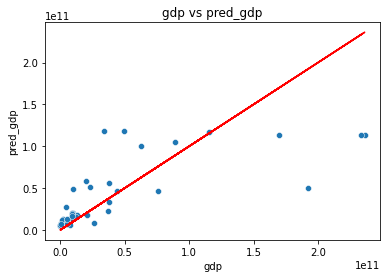

In [49]:
#散布図
sns.scatterplot(data=compare, x='gdp', y="pred_gdp")
plt.plot(compare["gdp"], compare["gdp"], color = 'red', label = 'x=y') 
plt.title('gdp vs pred_gdp') # グラフタイトル
plt.show()

決定係数（１に近いほど上手く予測できている）

In [50]:
#決定係数算出
print(r2_score(compare["gdp"], compare["pred_gdp"]))

0.5341719081631335


feature_importance（どの特徴量がどれくらい予測に寄与しているのかの確認）

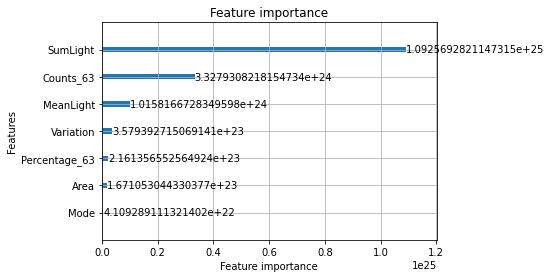

In [51]:
#feature_importance
lgb.plot_importance(model, importance_type="gain")

精度向上のため特徴量をSumLight、Counts_63、Modeに絞って学習させます

In [ ]:
#特徴量を絞って学習

In [52]:
#Objective（目的変数）とExplanatory（説明変数）の分離
Objective = NightLight[["SumLight","MeanLight","Area","Counts_63","Percentage_63","Mode","Variation"]]
Explanatory = NightLight[["gdp"]]

#学習データと検証データに分ける(学習データ128個、検証データ43個)
train_x2, valid_x2, train_y2, valid_y2 = train_test_split(Objective, Explanatory, test_size=0.25, random_state=42, shuffle=True)

In [53]:
#要らない特徴量を落とす
train_x2 = train_x2.drop(columns=["MeanLight","Variation","Percentage_63","Area"])
train_x2

,SumLight,Counts_63,Mode
171,288508.00,45.00,6.00
31,3406.00,0.00,5.00
174,2870.00,0.00,7.00
179,422933.00,184.00,4.00
187,31579.00,4.00,5.00
...,...,...,...
88,126592.00,73.00,6.00
127,4295.00,0.00,4.00
18,603350.00,36.00,4.00
112,200577.00,13.00,5.00


In [54]:
valid_x2 = valid_x2.drop(columns=["MeanLight","Variation","Percentage_63","Area"])
valid_x2

,SumLight,Counts_63,Mode
122,40965.00,43.00,5.00
68,8533.00,1.00,5.00
69,1570.00,0.00,5.00
165,141885.00,78.00,4.00
185,22.00,0.00,4.00
97,18948.00,22.00,17.00
161,59763.00,56.00,4.00
125,49049.00,0.00,5.00
130,35774.00,0.00,5.00
129,19261.00,26.00,4.00


In [55]:
#KFoldを使って5分割交差検証
from sklearn.model_selection import KFold
fold = KFold(n_splits=5, shuffle=True, random_state=42)
cv=list(fold.split(train_x2, train_y2))

# testデータの予測用
pred2 = np.zeros(valid_y2.shape[0])

params = {
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'objective': 'regression',
    'seed': 42,
    'learning_rate': 0.01,
    "n_jobs": -1,
    "verbose": -1,
}

for tr_idx, val_idx in cv:  
    x_tr, x_va = train_x2.iloc[tr_idx], train_x2.iloc[val_idx]
    y_tr, y_va = train_y2.iloc[tr_idx], train_y2.iloc[val_idx]
    
    # Datasetに入れて学習させる
    train_set = lgb.Dataset(x_tr, y_tr)
    val_set = lgb.Dataset(x_va, y_va, reference=train_set)
        
    # Training
    model = lgb.train(params, train_set, num_boost_round=10000, early_stopping_rounds=100,
                      valid_sets=[train_set, val_set], verbose_eval=-1)
    

    #予測したらexpで元に戻す
    test_pred = model.predict(valid_x2)
    #予測結果に負の値が出たら０に修正
    test_pred = np.where(test_pred < 0, 0, test_pred)
    pred2 += test_pred / 5  #  5fold回すので

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[62]	training's rmse: 4.68321e+10	valid_1's rmse: 4.68851e+10
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1723]	training's rmse: 3.49226e+10	valid_1's rmse: 3.80925e+10
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[728]	training's rmse: 3.70524e+10	valid_1's rmse: 4.4129e+10
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[907]	training's rmse: 3.48244e+10	valid_1's rmse: 3.84763e+10
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[247]	training's rmse: 4.01179e+10	valid_1's rmse: 3.72434e+10


In [56]:
valid_y2 = valid_y2.reset_index(drop=True)
pred_valid_y2=pd.DataFrame(pred2, columns=["pred_gdp"])

In [57]:
compare2 = pd.concat([valid_y2, pred_valid_y2], axis=1)
compare2

,gdp,pred_gdp
0,10181021770.43,19030439872.09
1,900628061.63,9379158828.01
2,825828703.63,8906741475.65
3,20661030000.00,23793458338.98
4,27101076.28,6721145421.92
5,10401851850.61,11487853697.67
6,12814961485.10,31842884785.37
7,4159330369.55,22955690245.07
8,9128843109.16,14399094133.39
9,3670515287.99,9301894690.08


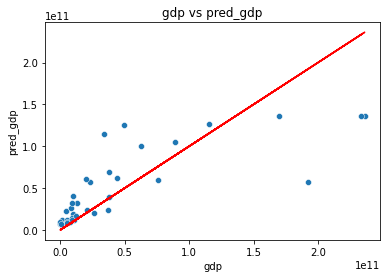

In [58]:
sns.scatterplot(data=compare2, x='gdp', y="pred_gdp")
plt.plot(compare2["gdp"], compare2["gdp"], color = 'red', label = 'x=y') 
plt.title('gdp vs pred_gdp') # グラフタイトル
plt.show()

In [59]:
from sklearn.metrics import r2_score
print(r2_score(compare2["gdp"], compare2["pred_gdp"]))

0.6106648056845366
